# Descripción

La compañía de seguros Sure Tomorrow quiere resolver varias tareas con la ayuda de machine learning y te pide que evalúes esa posibilidad.
- Tarea 1: encontrar clientes que sean similares a un cliente determinado. Esto ayudará a los agentes de la compañía con el marketing.
- Tarea 2: predecir la probabilidad de que un nuevo cliente reciba una prestación del seguro. ¿Puede un modelo de predictivo funcionar mejor que un modelo dummy?
- Tarea 3: predecir el número de prestaciones de seguro que un nuevo cliente pueda recibir utilizando un modelo de regresión lineal.
- Tarea 4: proteger los datos personales de los clientes sin afectar al modelo del ejercicio anterior. Es necesario desarrollar un algoritmo de transformación de datos que dificulte la recuperación de la información personal si los datos caen en manos equivocadas. Esto se denomina enmascaramiento u ofuscación de datos. Pero los datos deben protegerse de tal manera que no se vea afectada la calidad de los modelos de machine learning. No es necesario elegir el mejor modelo, basta con demostrar que el algoritmo funciona correctamente.


# Preprocesamiento y exploración de datos

## Inicialización

In [1]:
pip install scikit-learn --upgrade

  Using cached scikit_learn-1.6.1-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (18 kB)
Using cached scikit_learn-1.6.1-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.5 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
ERROR: Could not install packages due to an OSError: [Errno 13] Permission denied: 'COPYING'
Consider using the `--user` option or check the permissions.

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import math
import seaborn as sns

import sklearn.linear_model
import sklearn.metrics
import sklearn.neighbors 
import sklearn.preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MaxAbsScaler
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from IPython.display import display

## Carga de datos

Carga los datos y haz una revisión básica para comprobar que no hay problemas obvios.

In [3]:
df = pd.read_csv('/datasets/insurance_us.csv')

Renombramos las columnas para que el código se vea más coherente con su estilo.

In [4]:
df = df.rename(columns={'Gender': 'gender', 'Age': 'age', 'Salary': 'income', 'Family members': 'family_members', 'Insurance benefits': 'insurance_benefits'})

In [5]:
df.sample(10)

,gender,age,income,family_members,insurance_benefits
618,0,33.0,47100.0,0,0
2667,0,22.0,37000.0,1,0
3618,1,31.0,42600.0,2,0
2087,1,21.0,68000.0,2,0
4967,1,23.0,29000.0,2,0
2549,0,18.0,35300.0,2,0
1644,1,29.0,45300.0,1,0
2734,0,32.0,34300.0,1,0
2644,1,33.0,40000.0,1,0
545,0,32.0,50700.0,1,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   float64
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


In [7]:
# puede que queramos cambiar el tipo de edad (de float a int) aunque esto no es crucial

# se cambia el tipo de dato a entero
df['age'] = df['age'].astype(int)

In [8]:
# comprueba que la conversión se haya realizado con éxito
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   int64  
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(1), int64(4)
memory usage: 195.4 KB


In [56]:
# ahora echa un vistazo a las estadísticas descriptivas de los datos.# ¿Se ve todo bien?

In [9]:
# estadísticas descriptivas
df.describe()

,gender,age,income,family_members,insurance_benefits
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.499000,30.952800,39916.360000,1.194200,0.148000
std,0.500049,8.440807,9900.083569,1.091387,0.463183
min,0.000000,18.000000,5300.000000,0.000000,0.000000
25%,0.000000,24.000000,33300.000000,0.000000,0.000000
50%,0.000000,30.000000,40200.000000,1.000000,0.000000
75%,1.000000,37.000000,46600.000000,2.000000,0.000000
max,1.000000,65.000000,79000.000000,6.000000,5.000000


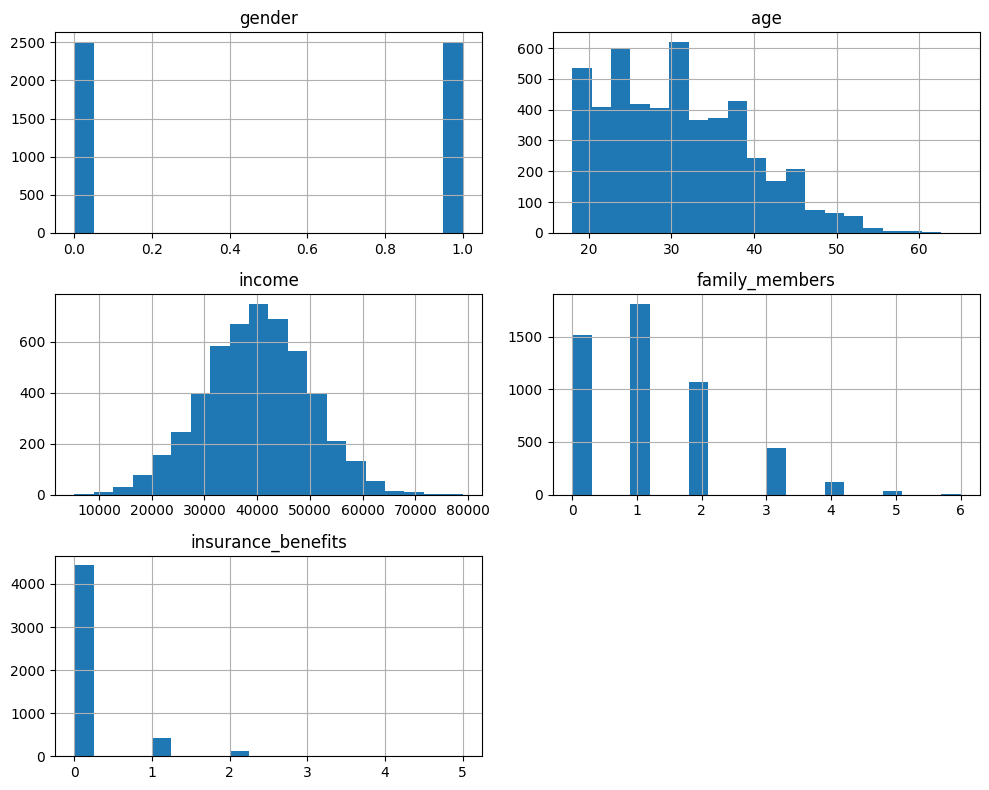

In [10]:
import matplotlib.pyplot as plt

# Histograma para cada variable numérica
df.hist(bins=20, figsize=(10,8))
plt.tight_layout()
plt.show()


**Las estadísticas descriptivas muestran que todas las variables tienen el mismo número de filas, lo que indica que no hay valores nulos en el DataFrame. Además, al observar los histogramas de las variables numéricas, no se identifican valores atípicos o comportamientos inusuales de manera significativa.**

## Análisis exploratorio de datos

Vamos a comprobar rápidamente si existen determinados grupos de clientes observando el gráfico de pares.

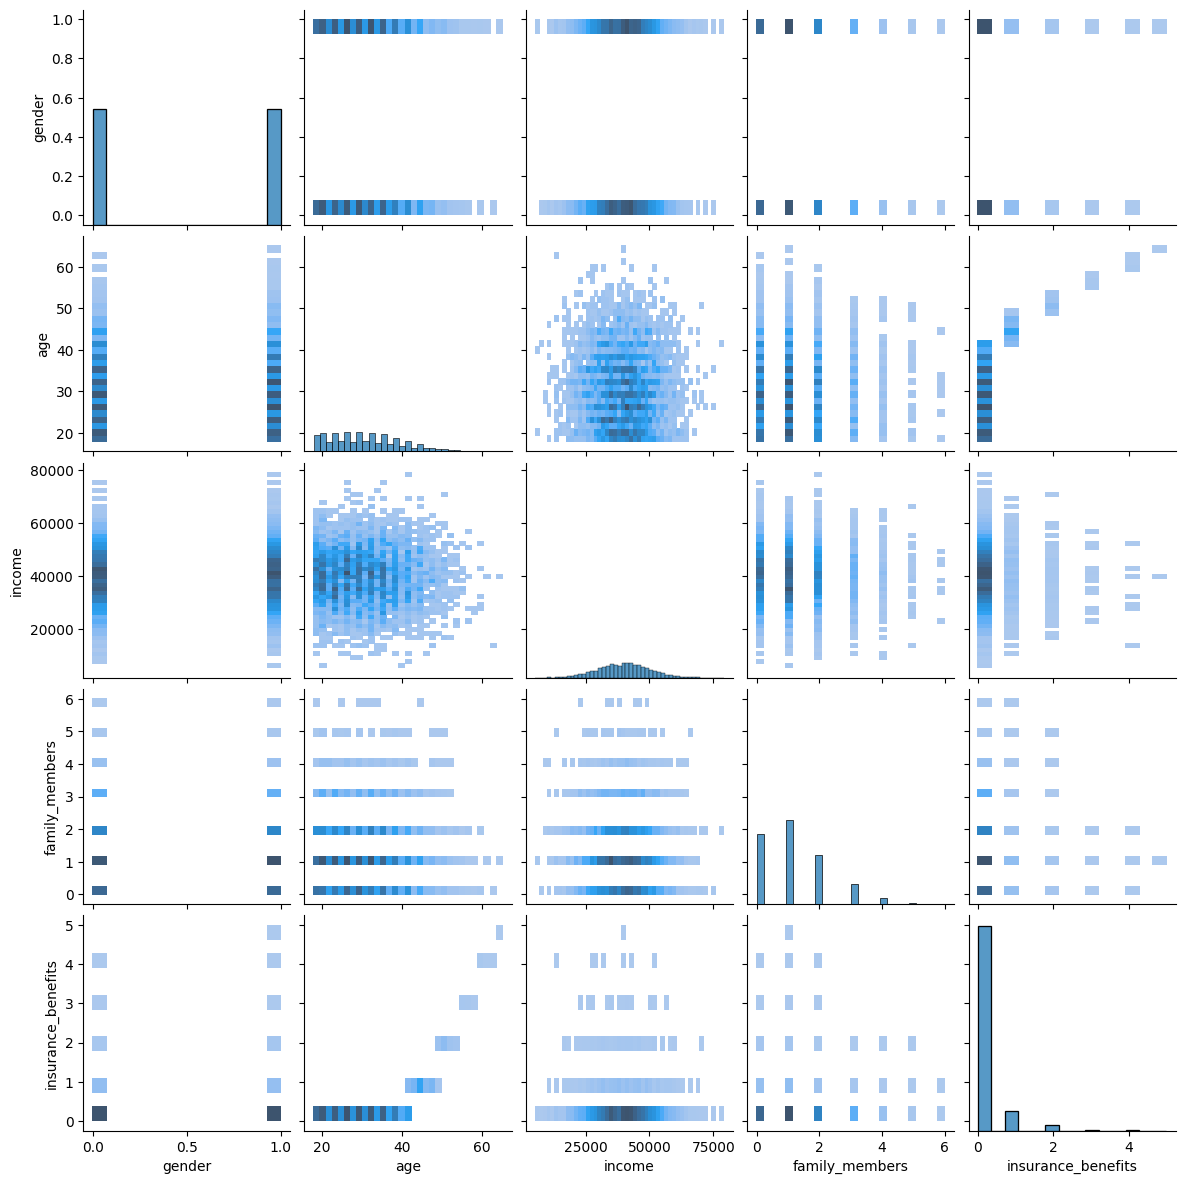

In [11]:
g = sns.pairplot(df, kind='hist')
g.fig.set_size_inches(12, 12)

De acuerdo, es un poco complicado detectar grupos obvios (clústeres) ya que es difícil combinar diversas variables simultáneamente (para analizar distribuciones multivariadas). Ahí es donde LA y ML pueden ser bastante útiles.

# Tarea 1. Clientes similares

En el lenguaje de ML, es necesario desarrollar un procedimiento que devuelva los k vecinos más cercanos (objetos) para un objeto dado basándose en la distancia entre los objetos.
Es posible que quieras revisar las siguientes lecciones (capítulo -> lección)- Distancia entre vectores -> Distancia euclidiana
- Distancia entre vectores -> Distancia Manhattan

Para resolver la tarea, podemos probar diferentes métricas de distancia.

Escribe una función que devuelva los k vecinos más cercanos para un $n^{th}$ objeto basándose en una métrica de distancia especificada. A la hora de realizar esta tarea no debe tenerse en cuenta el número de prestaciones de seguro recibidas.
Puedes utilizar una implementación ya existente del algoritmo kNN de scikit-learn (consulta [el enlace](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html#sklearn.neighbors.NearestNeighbors)) o tu propia implementación.
Pruébalo para cuatro combinaciones de dos casos- Escalado
  - los datos no están escalados
  - los datos se escalan con el escalador [MaxAbsScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MaxAbsScaler.html)
- Métricas de distancia
  - Euclidiana
  - Manhattan

Responde a estas preguntas:- ¿El hecho de que los datos no estén escalados afecta al algoritmo kNN? Si es así, ¿cómo se manifiesta?- ¿Qué tan similares son los resultados al utilizar la métrica de distancia Manhattan (independientemente del escalado)?

In [12]:
feature_names = ['gender', 'age', 'income', 'family_members']

In [15]:
def get_knn(df, n, k, metric):
    
    """
    Devuelve los k vecinos más cercanos

    :param df: DataFrame de pandas utilizado para encontrar objetos similares dentro del mismo lugar  
    :param n: número de objetos para los que se buscan los vecinos más cercanos  
    :param k: número de vecinos más cercanos a devolver
    :param métrica: nombre de la métrica de distancia    """
    
    nbrs = NearestNeighbors(n_neighbors=k, metric=metric)
    nbrs.fit(df[feature_names])
    nbrs_distances, nbrs_indices = nbrs.kneighbors([df.iloc[n][feature_names]], k, return_distance=True)
    
    df_res = pd.concat([
        df.iloc[nbrs_indices[0]], 
        pd.DataFrame(nbrs_distances.T, index=nbrs_indices[0], columns=['distance'])
        ], axis=1)
    
    return df_res

**Esta función devuelve los k vecinos más cercanos de un objeto específico utilizando una métrica de distancia (como la euclidiana o la manhattan). Usamos el modelo NearestNeighbors de scikit-learn para encontrar los vecinos más cercanos.**

Escalar datos.

In [16]:
feature_names = ['gender', 'age', 'income', 'family_members']

transformer_mas = sklearn.preprocessing.MaxAbsScaler().fit(df[feature_names].to_numpy())

df_scaled = df.copy()
df_scaled.loc[:, feature_names] = transformer_mas.transform(df[feature_names].to_numpy())

In [17]:
df_scaled.sample(5)

,gender,age,income,family_members,insurance_benefits
3844,0.0,0.446154,0.377215,0.166667,0
3172,0.0,0.538462,0.624051,0.166667,0
338,0.0,0.461538,0.555696,0.000000,0
4221,1.0,0.600000,0.663291,0.000000,0
1419,0.0,0.307692,0.382278,0.666667,0


Ahora, vamos a obtener registros similares para uno determinado, para cada combinación

In [18]:
n = 10  # Cliente a analizar
k = 5   # Nro de vecinos más cercanos

# Combinación 1: Datos no escalados, distancia Euclidiana
result_euclidean = get_knn(df, n, k, 'euclidean')
print("Vecinos con distancia Euclidiana (sin escalado):")
print(result_euclidean)

# Combinación 2: Datos escalados, distancia Euclidiana
result_scaled_euclidean = get_knn(df_scaled, n, k, 'euclidean')
print("\nVecinos con distancia Euclidiana (escalados):")
print(result_scaled_euclidean)


Vecinos con distancia Euclidiana (sin escalado):
      gender  age   income  family_members  insurance_benefits  distance
10         1   25  36600.0               1                   0  0.000000
4039       1   25  36600.0               2                   0  1.000000
2037       1   26  36600.0               0                   0  1.414214
3247       1   26  36600.0               2                   0  1.414214
1508       0   26  36600.0               0                   0  1.732051

Vecinos con distancia Euclidiana (escalados):
      gender       age    income  family_members  insurance_benefits  distance
10       1.0  0.384615  0.463291        0.166667                   0  0.000000
4377     1.0  0.384615  0.473418        0.166667                   0  0.010127
1389     1.0  0.369231  0.464557        0.166667                   0  0.015437
760      1.0  0.369231  0.462025        0.166667                   0  0.015437
2254     1.0  0.400000  0.455696        0.166667                   0  0

In [19]:
# Combinación 3: Datos no escalados, distancia Manhattan
result_manhattan = get_knn(df, n, k, 'manhattan')
print("Vecinos con distancia Manhattan (sin escalado):")
print(result_manhattan)

# Combinación 4: Datos escalados, distancia Manhattan
result_scaled_manhattan = get_knn(df_scaled, n, k, 'manhattan')
print("\nVecinos con distancia Manhattan (escalados):")
print(result_scaled_manhattan)

Vecinos con distancia Manhattan (sin escalado):
      gender  age   income  family_members  insurance_benefits  distance
10         1   25  36600.0               1                   0       0.0
4039       1   25  36600.0               2                   0       1.0
2037       1   26  36600.0               0                   0       2.0
3247       1   26  36600.0               2                   0       2.0
1508       0   26  36600.0               0                   0       3.0

Vecinos con distancia Manhattan (escalados):
      gender       age    income  family_members  insurance_benefits  distance
10       1.0  0.384615  0.463291        0.166667                   0  0.000000
4377     1.0  0.384615  0.473418        0.166667                   0  0.010127
1389     1.0  0.369231  0.464557        0.166667                   0  0.016650
760      1.0  0.369231  0.462025        0.166667                   0  0.016650
2254     1.0  0.400000  0.455696        0.166667                   0  0.0

Respuestas a las preguntas

**¿El hecho de que los datos no estén escalados afecta al algoritmo kNN? Si es así, ¿cómo se manifiesta?** 

Sí, no escalar los datos afecta el algoritmo kNN, ya que las características con valores más grandes, como _income_, dominan la métrica de distancia. Esto puede sesgar la elección de los vecinos más cercanos, ya que la distancia entre los objetos se verá influenciada principalmente por las características con mayor rango de valores.

**¿Qué tan similares son los resultados al utilizar la métrica de distancia Manhattan (independientemente del escalado)?** 

Los resultados utilizando la métrica Manhattan pueden ser similares a los de la distancia Euclidiana, especialmente cuando los datos están escalados, ya que ambas métricas dependen de las diferencias entre las características.

# Tarea 2. ¿Es probable que el cliente reciba una prestación del seguro?

En términos de machine learning podemos considerarlo como una tarea de clasificación binaria.

Con el valor de `insurance_benefits` superior a cero como objetivo, evalúa si el enfoque de clasificación kNN puede funcionar mejor que el modelo dummy.
Instrucciones:
- Construye un clasificador basado en KNN y mide su calidad con la métrica F1 para k=1...10 tanto para los datos originales como para los escalados. Sería interesante observar cómo k puede influir en la métrica de evaluación y si el escalado de los datos provoca alguna diferencia. Puedes utilizar una implementación ya existente del algoritmo de clasificación kNN de scikit-learn (consulta [el enlace](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)) o tu propia implementación.- Construye un modelo dummy que, en este caso, es simplemente un modelo aleatorio. Debería devolver "1" con cierta probabilidad. Probemos el modelo con cuatro valores de probabilidad: 0, la probabilidad de pagar cualquier prestación del seguro, 0.5, 1.
La probabilidad de pagar cualquier prestación del seguro puede definirse como
$$
P\{\text{prestación de seguro recibida}\}=\frac{\text{número de clientes que han recibido alguna prestación de seguro}}{\text{número total de clientes}}.
$$

Divide todos los datos correspondientes a las etapas de entrenamiento/prueba respetando la proporción 70:30.

In [20]:
# сalcula el objetivo
df['insurance_benefits_received'] = np.where(df['insurance_benefits']>0,1,0)

In [21]:
# comprueba el desequilibrio de clases con value_counts()

print(df['insurance_benefits_received'].value_counts())

0    4436
1     564
Name: insurance_benefits_received, dtype: int64


In [22]:
# división de los datos en entrenamiento y prueba (70%-30%)
X = df[['gender', 'age', 'income', 'family_members']]
y = df['insurance_benefits_received']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

In [23]:
# datos escalados
scaler = MaxAbsScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [24]:
def eval_classifier(y_true, y_pred):
    
    f1_score = sklearn.metrics.f1_score(y_true, y_pred)
    print(f'F1: {f1_score:.2f}')
    
# si tienes algún problema con la siguiente línea, reinicia el kernel y ejecuta el cuaderno de nuevo 
    cm = sklearn.metrics.confusion_matrix(y_true, y_pred, normalize='all')
    print('Matriz de confusión')
    print(cm)

In [25]:
# Entrenamiento y evaluación del modelo kNN para diferentes valores de k
for k in range(1, 11):
    print(f'Evaluación para k={k}')
    
    # Modelo kNN sin escalar
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    print(f"F1 sin escalar (k={k}): ", end="")
    eval_classifier(y_test, y_pred)
    
    # Modelo kNN con datos escalados
    knn.fit(X_train_scaled, y_train)
    y_pred_scaled = knn.predict(X_test_scaled)
    print(f"F1 con escalado (k={k}): ", end="")
    eval_classifier(y_test, y_pred_scaled)
    
    print()

Evaluación para k=1
F1 sin escalar (k=1): F1: 0.61
Matriz de confusión
[[0.87       0.02133333]
 [0.052      0.05666667]]
F1 con escalado (k=1): F1: 0.97
Matriz de confusión
[[0.88866667 0.00266667]
 [0.00466667 0.104     ]]

Evaluación para k=2
F1 sin escalar (k=2): F1: 0.41
Matriz de confusión
[[0.88733333 0.004     ]
 [0.08       0.02866667]]
F1 con escalado (k=2): F1: 0.93
Matriz de confusión
[[8.90666667e-01 6.66666667e-04]
 [1.40000000e-02 9.46666667e-02]]

Evaluación para k=3
F1 sin escalar (k=3): F1: 0.41
Matriz de confusión
[[0.88       0.01133333]
 [0.078      0.03066667]]
F1 con escalado (k=3): F1: 0.95
Matriz de confusión
[[0.88933333 0.002     ]
 [0.00866667 0.1       ]]

Evaluación para k=4
F1 sin escalar (k=4): F1: 0.28
Matriz de confusión
[[0.88866667 0.00266667]
 [0.09066667 0.018     ]]
F1 con escalado (k=4): F1: 0.91
Matriz de confusión
[[0.88933333 0.002     ]
 [0.01666667 0.092     ]]

Evaluación para k=5
F1 sin escalar (k=5): F1: 0.27
Matriz de confusión
[[0.88533

In [26]:
# generar la salida de un modelo aleatorio

def rnd_model_predict(P, size, seed=42):

    rng = np.random.default_rng(seed=seed)
    return rng.binomial(n=1, p=P, size=size)

In [27]:
for P in [0, df['insurance_benefits_received'].sum() / len(df), 0.5, 1]:

    print(f'La probabilidad: {P:.2f}')
    y_pred_rnd = rnd_model_predict(P, df.shape[0], seed=42)
        
    eval_classifier(df['insurance_benefits_received'], y_pred_rnd)
    
    print()

La probabilidad: 0.00
F1: 0.00
Matriz de confusión
[[0.8872 0.    ]
 [0.1128 0.    ]]

La probabilidad: 0.11
F1: 0.12
Matriz de confusión
[[0.7914 0.0958]
 [0.0994 0.0134]]

La probabilidad: 0.50
F1: 0.20
Matriz de confusión
[[0.456  0.4312]
 [0.053  0.0598]]

La probabilidad: 1.00
F1: 0.20
Matriz de confusión
[[0.     0.8872]
 [0.     0.1128]]



**El modelo KNN escalado supera al modelo dummy en rendimiento. El KNN, especialmente con k bajos, ofrece una buena precisión (F1 > 0.9 con escalado), mientras que el modelo dummy tiene un F1 muy bajo (entre 0 y 0.2). Por lo tanto, el KNN escalado es la opción recomendada, ya que brinda resultados mucho mejores que el modelo aleatorio.**

# Tarea 3. Regresión (con regresión lineal)

Con `insurance_benefits` como objetivo, evalúa cuál sería la RECM de un modelo de regresión lineal.

Construye tu propia implementación de regresión lineal. Para ello, recuerda cómo está formulada la solución de la tarea de regresión lineal en términos de LA. Comprueba la RECM tanto para los datos originales como para los escalados. ¿Puedes ver alguna diferencia en la RECM con respecto a estos dos casos?

Denotemos- $X$: matriz de características; cada fila es un caso, cada columna es una característica, la primera columna está formada por unidades- $y$ — objetivo (un vector)- $\hat{y}$ — objetivo estimado (un vector)- $w$ — vector de pesos
La tarea de regresión lineal en el lenguaje de las matrices puede formularse así:
$$
y = Xw
$$

El objetivo de entrenamiento es entonces encontrar esa $w$ w que minimice la distancia L2 (ECM) entre $Xw$ y $y$:

$$
\min_w d_2(Xw, y) \quad \text{or} \quad \min_w \text{MSE}(Xw, y)
$$

Parece que hay una solución analítica para lo anteriormente expuesto:
$$
w = (X^T X)^{-1} X^T y
$$

La fórmula anterior puede servir para encontrar los pesos $w$ y estos últimos pueden utilizarse para calcular los valores predichos
$$
\hat{y} = X_{val}w
$$

Divide todos los datos correspondientes a las etapas de entrenamiento/prueba respetando la proporción 70:30. Utiliza la métrica RECM para evaluar el modelo.

In [28]:
class MyLinearRegression:
    
    def __init__(self):
        
        self.weights = None
    
    def fit(self, X, y):
        
        # añadir las unidades
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        self.weights = np.linalg.inv(X2.T @ X2) @ X2.T @ y

    def predict(self, X):
        
        # añadir las unidades
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        y_pred = X2 @ self.weights
        
        return y_pred

In [29]:
def eval_regressor(y_true, y_pred):
    
    rmse = math.sqrt(sklearn.metrics.mean_squared_error(y_true, y_pred))
    print(f'RMSE: {rmse:.2f}')
    
    r2_score = math.sqrt(sklearn.metrics.r2_score(y_true, y_pred))
    print(f'R2: {r2_score:.2f}')    

In [30]:
X = df[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df['insurance_benefits'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

lr = MyLinearRegression()

lr.fit(X_train, y_train)
print(lr.weights)



[-9.43539012e-01  3.57495491e-02  1.64272726e-02 -2.60743659e-07
 -1.16902127e-02]


In [31]:
# Escalar los datos
scaler = MaxAbsScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Modelo con datos no escalados
lr.fit(X_train, y_train)
print("Modelo con datos no escalados")
y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

print("\nModelo con datos escalados")
# Modelo con datos escalados
lr.fit(X_train_scaled, y_train)
y_test_pred_scaled = lr.predict(X_test_scaled)
eval_regressor(y_test, y_test_pred_scaled)

Modelo con datos no escalados
RMSE: 0.34
R2: 0.66

Modelo con datos escalados
RMSE: 0.34
R2: 0.66


**No se observa diferencia entre el RECM y el R2 de los datos originales con los de los datos escalados.**

# Tarea 4. Ofuscar datos

Lo mejor es ofuscar los datos multiplicando las características numéricas (recuerda que se pueden ver como la matriz $X$) por una matriz invertible $P$. 

$$
X' = X \times P
$$

Trata de hacerlo y comprueba cómo quedarán los valores de las características después de la transformación. Por cierto, la propiedad de invertibilidad es importante aquí, así que asegúrate de que $P$ sea realmente invertible.

Puedes revisar la lección 'Matrices y operaciones matriciales -> Multiplicación de matrices' para recordar la regla de multiplicación de matrices y su implementación con NumPy.

In [32]:
personal_info_column_list = ['gender', 'age', 'income', 'family_members']
df_pn = df[personal_info_column_list]

In [33]:
X = df_pn.to_numpy()

Generar una matriz aleatoria $P$.

In [34]:
rng = np.random.default_rng(seed=42)
P = rng.random(size=(X.shape[1], X.shape[1]))

Comprobar que la matriz P sea invertible

In [35]:
# prueba de que la matriz P es invertible
P_inv = np.linalg.inv(P)
print('\nMatriz aleatoria\n',P)
print('\nInversa de matriz aleatoria\n',P_inv)




Matriz aleatoria
 [[0.77395605 0.43887844 0.85859792 0.69736803]
 [0.09417735 0.97562235 0.7611397  0.78606431]
 [0.12811363 0.45038594 0.37079802 0.92676499]
 [0.64386512 0.82276161 0.4434142  0.22723872]]

Inversa de matriz aleatoria
 [[ 0.41467992 -1.43783972  0.62798546  1.14001268]
 [-1.06101789  0.44219337  0.1329549   1.18425933]
 [ 1.42362442  1.60461607 -2.0553823  -1.53699695]
 [-0.11128575 -0.65813802  1.74995517 -0.11816316]]


In [36]:
# se ofuscan los datos utilizando formula 𝑋′=𝑋×𝑃
X_prime = X @ P

print("\nMatriz de características original (X):\n", X)
print("\nMatriz de características ofuscada (X'):\n", X_prime)


Matriz de características original (X):
 [[1.00e+00 4.10e+01 4.96e+04 1.00e+00]
 [0.00e+00 4.60e+01 3.80e+04 1.00e+00]
 [0.00e+00 2.90e+01 2.10e+04 0.00e+00]
 ...
 [0.00e+00 2.00e+01 3.39e+04 2.00e+00]
 [1.00e+00 2.20e+01 3.27e+04 3.00e+00]
 [1.00e+00 2.80e+01 4.06e+04 1.00e+00]]

Matriz de características ofuscada (X'):
 [[ 6359.71527314 22380.40467609 18424.09074184 46000.69669016]
 [ 4873.29406479 17160.36702982 14125.78076133 35253.45577301]
 [ 2693.11742928  9486.397744    7808.83156024 19484.86063067]
 ...
 [ 4346.2234249  15289.24126492 12586.16264392 31433.50888552]
 [ 4194.09324155 14751.9910242  12144.02930637 30323.88763426]
 [ 5205.46827354 18314.24814446 15077.01370762 37649.59295455]]


¿Puedes adivinar la edad o los ingresos de los clientes después de la transformación?

No, después de la transformación 𝑋′ los valores de las características están alterados, por lo que no se puede identificar directamente la edad o ingresos de los clientes. Ejemplo:

In [37]:
df_prime = pd.DataFrame(X_prime,columns = personal_info_column_list)

df_prime.head()

,gender,age,income,family_members
0,6359.715273,22380.404676,18424.090742,46000.696690
1,4873.294065,17160.367030,14125.780761,35253.455773
2,2693.117429,9486.397744,7808.831560,19484.860631
3,5345.603937,18803.227203,15479.148373,38663.061863
4,3347.176735,11782.829283,9699.998942,24211.273378


¿Puedes recuperar los datos originales de $X'$ si conoces $P$? Intenta comprobarlo a través de los cálculos moviendo $P$ del lado derecho de la fórmula anterior al izquierdo. En este caso las reglas de la multiplicación matricial son realmente útiles

Muestra los tres casos para algunos clientes- Datos originales
- El que está transformado- El que está invertido (recuperado)

**Si conocemos la matriz 𝑃 y su inversa 𝑃−1, podemos recuperar los datos originales de 𝑋′. La fórmula $ 𝑋=𝑋′𝑃−1 $ permite hacer esta recuperación.**

In [38]:
# Muestra de datos originales 
print("Datos originales (X):")
print(X)

# Muestra de datos transformados
print("\nDatos transformados (X'):")
print(X_prime)

# Recuperación de los datos originales de X' usando X' * P_inv
X_original = X_prime @ P_inv

# Muestra de datos recuperados
print("\nDatos recuperados (de X') usando P^-1:")
print(X_original)

Datos originales (X):
[[1.00e+00 4.10e+01 4.96e+04 1.00e+00]
 [0.00e+00 4.60e+01 3.80e+04 1.00e+00]
 [0.00e+00 2.90e+01 2.10e+04 0.00e+00]
 ...
 [0.00e+00 2.00e+01 3.39e+04 2.00e+00]
 [1.00e+00 2.20e+01 3.27e+04 3.00e+00]
 [1.00e+00 2.80e+01 4.06e+04 1.00e+00]]

Datos transformados (X'):
[[ 6359.71527314 22380.40467609 18424.09074184 46000.69669016]
 [ 4873.29406479 17160.36702982 14125.78076133 35253.45577301]
 [ 2693.11742928  9486.397744    7808.83156024 19484.86063067]
 ...
 [ 4346.2234249  15289.24126492 12586.16264392 31433.50888552]
 [ 4194.09324155 14751.9910242  12144.02930637 30323.88763426]
 [ 5205.46827354 18314.24814446 15077.01370762 37649.59295455]]

Datos recuperados (de X') usando P^-1:
[[ 1.00000000e+00  4.10000000e+01  4.96000000e+04  1.00000000e+00]
 [-4.47363596e-12  4.60000000e+01  3.80000000e+04  1.00000000e+00]
 [-2.51586878e-12  2.90000000e+01  2.10000000e+04  9.52452315e-13]
 ...
 [-1.92837871e-12  2.00000000e+01  3.39000000e+04  2.00000000e+00]
 [ 1.00000000e

Seguramente puedes ver que algunos valores no son exactamente iguales a los de los datos originales. ¿Cuál podría ser la razón de ello?

**Las pequeñas diferencias al recuperar los datos originales se pueden deber al redondeo de decimales durante los cálculos. Aunque no son idénticos, los valores son muy similares, por lo que no afectan significativamente los resultados.**

## Prueba de que la ofuscación de datos puede funcionar con regresión lineal

En este proyecto la tarea de regresión se ha resuelto con la regresión lineal. Tu siguiente tarea es demostrar _analytically_ que el método de ofuscación no afectará a la regresión lineal en términos de valores predichos, es decir, que sus valores seguirán siendo los mismos. ¿Lo puedes creer? Pues no hace falta que lo creas, ¡tienes que que demostrarlo!

Entonces, los datos están ofuscados y ahora tenemos $X \times P$ en lugar de tener solo $X$. En consecuencia, hay otros pesos $w_P$ como
$$
w = (X^T X)^{-1} X^T y \quad \Rightarrow \quad w_P = [(XP)^T XP]^{-1} (XP)^T y
$$

¿Cómo se relacionarían $w$ y $w_P$ si simplificáramos la fórmula de $w_P$ anterior? 

¿Cuáles serían los valores predichos con $w_P$? 

¿Qué significa esto para la calidad de la regresión lineal si esta se mide mediante la RECM?
Revisa el Apéndice B Propiedades de las matrices al final del cuaderno. ¡Allí encontrarás fórmulas muy útiles!

No es necesario escribir código en esta sección, basta con una explicación analítica.

**Respuesta (Prueba analítica)**

Al simplificar la formula $w_P = [(XP)^T XP]^{-1} (XP)^T$ usando la propiedad de reversibilidad de la transposición de un producto de matrices $(AB)^{T}=B^{T}A^{T}$ se obtiene:
$$ \quad w_P = [P^TX^T XP]^{-1} P^TX^Ty $$

si ademas se utiliza la propiedad asociativa de la multiplicación y la propiedad $(AB)^{-1}=B^{-1}A^{-1}$ se obtiene finalmente esta formula:

$$ \quad w_P = [P]^{-1}(X^TX)^{-1}[P^T]^{-1}P^TX^Ty $$

considerando que tenemos un P traspuesta y una P traspuesta inversa multiplicandose, $[P^T]^{-1}P^T$ estan pasan a ser un 1(Identidad), según la propiedad de identidad multiplicativa $IA = AI = A$ y recordando que  $ w = (X^T X)^{-1} X^Ty $ tenemos que finalmente:

$$ \quad w_P = [P]^{-1}(X^TX)^{-1}X^Ty = [P]^{-1}w $$

Lo que nos indica que los nuevos valores estan relacionados con los valores (pesos) originales. Ademas, sabemos que los valores predichos en un modelo de regresión lineal se obtienen con la formula: 
$$
\hat{y} = Xw
$$
y si consideramos que para los datos ofuscados son $ X' = X \times P $ entonces los valores predichos serian: 
$$
\hat{y}_P = X'w_P = (X \times P)([P]^{-1}w)
$$
dado que nuevamente se genera una matriz identidad por las multiplicaciones de las P, obtenemos que:
$$
\hat{y}_P = Xw = \hat{y}
$$
Los valores predichos con los datos ofuscados son los mismos que los valores predichos con los datos originales, y dado que las predicciones no cambian, esto significa que el rendimiento del modelo no se ve afectado por la ofuscación de los datos. La calidad del modelo, medida a través de RECM, será la misma con los datos ofuscados que con los datos originales.

## Prueba de regresión lineal con ofuscación de datos

Ahora, probemos que la regresión lineal pueda funcionar, en términos computacionales, con la transformación de ofuscación elegida.
Construye un procedimiento o una clase que ejecute la regresión lineal opcionalmente con la ofuscación. Puedes usar una implementación de regresión lineal de scikit-learn o tu propia implementación.
Ejecuta la regresión lineal para los datos originales y los ofuscados, compara los valores predichos y los valores de las métricas RMSE y $R^2$. ¿Hay alguna diferencia?

**Procedimiento**

- Crea una matriz cuadrada $P$ de números aleatorios.- Comprueba que sea invertible. Si no lo es, repite el primer paso hasta obtener una matriz invertible.
- Utiliza $XP$ como la nueva matriz de características

**Ya que en la tarea 4 se genero una matriz P invertible y se ofuscaron los datos, generando la matriz "X_prime", esta se reutilizara como la nueva matriz de caracteristicas**


In [46]:
X_train_prime, X_test_prime, y_train, y_test = train_test_split(X_prime, y, test_size=0.3, random_state=12345)

lr.fit(X_train_prime, y_train)

y_test_pred_prime = lr.predict(X_test_prime)
eval_regressor(y_test, y_test_pred_prime)

RMSE: 0.34
R2: 0.66


se vuelve a hacer la regresión lineal con los datos originales para hacer las comparación:

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

lr.fit(X_train, y_train)

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

RMSE: 0.34
R2: 0.66


**La regresión lineal sigue funcionando correctamente tanto con los datos originales como con los datos ofuscados. Las métricas de rendimiento son prácticamente las mismas, lo que confirma que el proceso de ofuscación de datos no afecta negativamente el rendimiento del modelo.**

# Conclusiones

- De la tarea 1 concluimos que el escalado de los datos tiene un impacto importante en el algoritmo kNN, ya que sin escalar, las características con mayores valores (como los ingresos) dominan la distancia, sesgando la selección de vecinos. Al escalar los datos, todas las características tienen el mismo peso, mejorando la precisión. Las métricas de distancia Euclidiana y Manhattan producen resultados similares, especialmente cuando los datos están escalados.

- Con respecto a la tarea 2, el clasificador kNN con datos escalados superó al modelo dummy en rendimiento, con un F1 superior a 0.9 para valores bajos de k, mientras que el modelo dummy presentó un F1 muy bajo (0-0.2). Esto demuestra que kNN escalado es mucho más eficaz para predecir las prestaciones del seguro.

- En la tarea 3 al aplicar regresión lineal para predecir las prestaciones del seguro, se obtuvo un RMSE de 0.34 y un R² de 0.66 tanto en los datos originales como en los escalados. Esto sugiere que el escalado de los datos no tiene un impacto significativo en la calidad del modelo en términos de estas métricas. La implementación de regresión lineal basada en la fórmula analítica proporcionó resultados consistentes en ambos casos.

- La ofuscación de datos mediante una matriz invertible no afecta las predicciones de un modelo de regresión lineal. A través de una demostración analítica en la tarea 4, se muestra que los valores predichos con los datos ofuscados son idénticos a los obtenidos con los datos originales, lo que implica que el rendimiento del modelo y la RECM no se ven alterados, tal como se comprueba en el paso 5.